<a href="https://colab.research.google.com/github/FelipeFerAl/SignalsTheory/blob/main/Relaci%C3%B3nSe%C3%B1alRuido.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Librerias

In [ ]:
from IPython.display import clear_output, Audio
from google.colab import drive
from scipy.signal import welch, butter, filtfilt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
import librosa
import sys

sys.setrecursionlimit(1300)

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Funciones

In [ ]:
#@title Carga de datos
def carga():
  """
  Realiza la creación de los archivos a trabajar
  Entrada: None
  Salida: Etiquetas de los audios, matriz de audios, frecuencia de muestreo
  """
  base = '/content/drive/MyDrive/Radios_etiquetados.xlsx'
  df_base = pd.read_excel(base)

  audio_folder = '/content/drive/MyDrive/ANEaudios.zip'
  with zipfile.ZipFile(audio_folder,'r') as zip_ref:
    zip_ref.extractall('/content/ANEaudios')
  audios = []
  for filename in os.listdir('/content/ANEaudios/'):
    archivo = os.path.join('/content/ANEaudios',filename)
    y, fr = librosa.load(archivo,sr=44100)
    audios.append(y)

  M_audios = np.array(audios)
  return df_base, M_audios, fr

def carga2():
  """
  Transformada de las señales a PSD dependiendo su etiqueta y promediando
  Entrada: None
  Salida: Promedio de las transformaciones en base a la etiqueta
  """
  etiquetas = '/content/drive/MyDrive/Radios_etiquetados.xlsx'
  df = pd.read_excel(etiquetas)
  audios_0 = []
  audios_1 = []

  for i in range(len(df)):
    filename = df.loc[i,'Audio']
    if filename in os.listdir('/content/ANEaudios/'):
      if df.loc[i,'Etiqueta'] == 0:
        archivo = os.path.join('/content/ANEaudios',filename)
        y, fr = librosa.load(archivo,sr=44100)
        audios_0.append(y)
      else:
        archivo = os.path.join('/content/ANEaudios',filename)
        y, fr = librosa.load(archivo,sr=44100)
        audios_1.append(y)

  audios_0 = np.mean(audios_0, axis=0)
  audios_1 = np.mean(audios_1, axis=0)
  return audios_0, audios_1

In [ ]:
#@title Normalización
def norm(y):
  """
  Normalización de los datos en base al máximo de presencia de señal
  Entrada: Señal a normalizar
  Salida: Señal normalizada
  """
  if y.ndim == 1:
    scal = max(A1_trans)
    y_norm = y/scal
  else:
    y_norm = []
    for sig in y:
      scal = max(sig)
      y_norm.append(sig/scal)
    y_norm = np.array(y_norm)
  return y_norm

In [ ]:
#@title Filtro
def filtro(y,fm,lf,hf,order):
  """
  Filtra la señal que se le ingresa
  Entrada: Señal a filtrar, frecuencia de muestreo, frecuencia baja, frecuencia alta, orden del filtro
  Salida: Señal filtrada
  """
  filtro = 'bandpass'
  out='ba'
  a, b = butter(order, [lf,hf], btype=filtro, fs=fm, output=out)
  y_filt = filtfilt(a, b, y)
  return y_filt

In [ ]:
#@title Transformación
def trans(y, fm):
  """
  Transforma todas las señales individualmente a PSD
  Entrada: Señal a transformar, frecuencia de muestreo
  Salida: PSD de la señal y vector de frecuencias
  """
  if y.ndim == 1:
    freq, p = welch(y, fm)
    PSD = np.array([p])
    PSD = PSD.reshape(129)
  else:
    PSD = []
    freq = welch(y[0],fm)[0]
    for sig in y:
      p = welch(sig, fm)[1]
      PSD.append(p)
    PSD = np.array(PSD)
  return PSD, freq

In [ ]:
#@title Graficas
def grafica():
  """
  Grafica las señales
  Entrada: None
  Salida: Grafica
  """
  plt.figure(figsize=(16,5))
  plt.semilogy(freq, A0_norm, label='Ruido promedio', linestyle='--')
  plt.semilogy(freq, A1_norm, label='Señal promedio', linestyle='--')
  plt.semilogy(freq, PSD_norm[250], label='Señal 250 de audio')
  plt.semilogy(freq, PSD_norm[500], label='Señal 500 de ruido')
  plt.xlabel('Frecuencia (Hz)')
  plt.ylabel('PSD')
  plt.title('Promedio y Total en Logaritmos')
  plt.legend()
  plt.show()

#Código


In [ ]:
#Obteniendo los audios (Totales y por etiqueta) y frecuencia de muestreo
df, M_audios, fr = carga()
audios_0, audios_1 = carga2()
t = np.linspace(0,1,M_audios.shape[1])

In [ ]:
#Transformada de la matriz completa
PSD, freq = trans(M_audios, fr)

#Transformada por promedio de etiquetas
A0_trans = trans(audios_0, fr)[0]
A1_trans = trans(audios_1, fr)[0]

In [ ]:
#Normalización de los audios
PSD_norm =  norm(PSD)
A0_norm = norm(A0_trans)
A1_norm = norm(A1_trans)

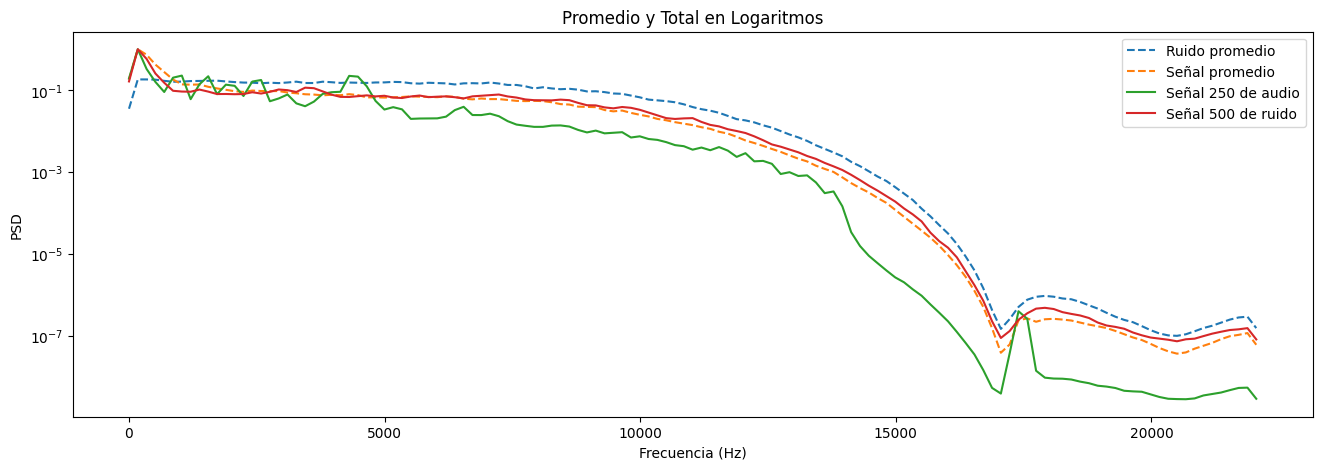

In [ ]:
grafica()

#SNR

In [ ]:
noise_power = np.mean(A0_trans**2)
signal_power = np.mean(A1_trans**2)

SNR = 10 * np.log10(signal_power / noise_power)
print(f"La relación señal-ruido es {SNR:.2f}")

La relación señal-ruido es 2.47
